# Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: TBA
* Instructor name: James M Irving, Ph.D.
* Blog post URL: TBA


## Project Roadmap

#### Objectives:
The objective of this project is to produce a classification model that will predict if customers will cease their telephone services with Syria Tel.

#### Business Case:
The targeted audience would be the customer service, marketing and sales departments of the company.  The classification model will provides the audience with insights as to why we might lose a customer's subscription.  Knowing these factors is crucial as we can take corrective and preventive actions to retain the customers and prevent revenue loss.

#### Project Approach
We will follows the OSEMN framework during the project execution.  Besides, we will develop and fine tune 4 classification models using Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost.  The classifier that produces the best recall score will be adopted.

***
## Obtain Data

### Import Libraries

In [1]:
# Import various libraries
import time
from time import process_time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from my_Func import *
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Import Data

In [2]:
# Import the dataset
df = pd.read_csv(r'csv\bigml_59c28831336c6604c800002a.csv')
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

***
## Clean and Scrub Data

### Inpect Columns Data Type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The dataset contains both numerical and categorical data type.  One hot encoding will be required for categorical data type.</li>
        <li>Phone number column can be dropped as it doesn't provide useful information to the model.</li>
        <li>Churn column will be our labels.  We will change its bool data type to int64.</li>
        <li>Column names contain spaces.  Replace with underscore.</li>
    </ul>
</div>

In [4]:
# Drop the phone number column
df.drop(columns='phone number', axis=1, inplace=True)

# Confirm drop
(df.columns == 'phone number').sum()

0

In [5]:
# Convert boolean to interger
df['churn'] = df['churn'].map({True:1, False:0})

# Verify changes
df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [6]:
# Replace spaces in column names with underscore
df.columns = df.columns.str.replace(' ', '_', )

# Verify changes
df.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'churn'],
      dtype='object')

### Inspect Unique Values in Columns

In [7]:
df.nunique()

state                       51
account_length             212
area_code                    3
international_plan           2
voice_mail_plan              2
number_vmail_messages       46
total_day_minutes         1667
total_day_calls            119
total_day_charge          1667
total_eve_minutes         1611
total_eve_calls            123
total_eve_charge          1440
total_night_minutes       1591
total_night_calls          120
total_night_charge         933
total_intl_minutes         162
total_intl_calls            21
total_intl_charge          162
customer_service_calls      10
churn                        2
dtype: int64

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are 51 unique values in the state column.  To keep the model simple, we will group States by region.</li>
        <li>We will use the States to Region mapping obtained from <a href="https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv"</a>Github</li>
    </ul>
</div>

In [8]:
# Import the States to Region mapping dataset
df_reg = pd.read_csv('csv\st_to_rg.csv')

# Preview data
df_reg.head()

state region
0    AK   West
1    AL  South
2    AR  South
3    AZ   West
4    CA   West

In [9]:
# Merge the two dataframe
df_reg = pd.merge(df, df_reg, on='state', )

# Preview data
df_reg.head()

state  account_length  area_code international_plan voice_mail_plan  \
0    KS             128        415                 no             yes   
1    KS              70        408                 no              no   
2    KS              92        408                yes              no   
3    KS             137        408                 no              no   
4    KS             132        415                 no              no   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                     25              265.1              110   
1                      0              232.1              122   
2                      0               62.6              111   
3                      0              205.9               88   
4                      0               83.4              110   

   total_day_charge  total_eve_minutes  ...  total_eve_charge  \
0             45.07              197.4  ...             16.78   
1             39.46              292.3  ...             24.85   
2             10.64              180.6  ...             15.35   
3             35.00              209.3  ...             17.79   
4             14.18              232.2  ...             19.74   

   total_night_minutes  total_night_calls  total_night_charge  \
0                244.7                 91               11.01   
1                201.2                112                9.05   
2                221.7                 80                9.98   
3                289.9                 84               13.05   
4                146.7                114                6.60   

   total_intl_minutes  total_intl_calls  total_intl_charge  \
0                10.0                 3               2.70   
1                 0.0                 0               0.00   
2                10.4                 2               2.81   
3                14.5                 4               3.92   
4                 7.6                 5               2.05   

   customer_service_calls  churn   region  
0                       1      0  Midwest  
1                       3      0  Midwest  
2                       1      1  Midwest  
3                       2      0  Midwest  
4                       1      0  Midwest  

[5 rows x 21 columns]

In [10]:
# Drop the state column
df_reg.drop(columns='state', axis=1, inplace=True)

# Verify drop and check unique values
df_reg.select_dtypes(object).nunique()

international_plan    2
voice_mail_plan       2
region                4
dtype: int64

### Check Null Values

In [11]:
# Check for null values
df_reg.isna().sum()

account_length            0
area_code                 0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
region                    0
dtype: int64

***
## Explore Data

### Descriptive Analysis

In [12]:
# Get descriptive analysis of the dataframe
df_reg.describe()

account_length    area_code  number_vmail_messages  total_day_minutes  \
count     3333.000000  3333.000000            3333.000000        3333.000000   
mean       101.064806   437.182418               8.099010         179.775098   
std         39.822106    42.371290              13.688365          54.467389   
min          1.000000   408.000000               0.000000           0.000000   
25%         74.000000   408.000000               0.000000         143.700000   
50%        101.000000   415.000000               0.000000         179.400000   
75%        127.000000   510.000000              20.000000         216.400000   
max        243.000000   510.000000              51.000000         350.800000   

       total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   
std          20.069084          9.259435          50.713844        19.922625   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.430000         166.600000        87.000000   
50%         101.000000         30.500000         201.400000       100.000000   
75%         114.000000         36.790000         235.300000       114.000000   
max         165.000000         59.640000         363.700000       170.000000   

       total_eve_charge  total_night_minutes  total_night_calls  \
count       3333.000000          3333.000000        3333.000000   
mean          17.083540           200.872037         100.107711   
std            4.310668            50.573847          19.568609   
min            0.000000            23.200000          33.000000   
25%           14.160000           167.000000          87.000000   
50%           17.120000           201.200000         100.000000   
75%           20.000000           235.300000         113.000000   
max           30.910000           395.000000         175.000000   

       total_night_charge  total_intl_minutes  total_intl_calls  \
count         3333.000000         3333.000000       3333.000000   
mean             9.039325           10.237294          4.479448   
std              2.275873            2.791840          2.461214   
min              1.040000            0.000000          0.000000   
25%              7.520000            8.500000          3.000000   
50%              9.050000           10.300000          4.000000   
75%             10.590000           12.100000          6.000000   
max             17.770000           20.000000         20.000000   

       total_intl_charge  customer_service_calls        churn  
count        3333.000000             3333.000000  3333.000000  
mean            2.764581                1.562856     0.144914  
std             0.753773                1.315491     0.352067  
min             0.000000                0.000000     0.000000  
25%             2.300000                1.000000     0.000000  
50%             2.780000                1.000000     0.000000  
75%             3.270000                2.000000     0.000000  
max             5.400000                9.000000     1.000000

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Some columns exhibit great variances.  Data normalization will be required.</li>
        <li>No details can be found regarding the unit for "account length".  However, based on the "total day calls" values, it is safe to assume the unit for "account length" is in days.</li>
        <li>Based on the above assumption, the data seems to represent new customers as the max value in "account length" is 243 days or 8.1 months and an average days of 101.</li>
    </ul>
</div>

### Investigate Churn Column

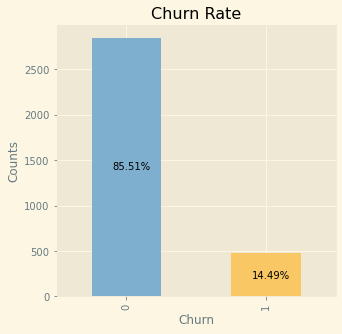

In [13]:
# # Checking churn data distribution
nc_percent = round(df_reg.churn.value_counts(normalize=True)[0]*100,2)
c_percent = round(df_reg.churn.value_counts(normalize=True)[1]*100,2)

with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(5,5))
    df_reg['churn'].value_counts().plot(kind='bar', color=['#7FAFCE',
                                                           '#F9C764'])
    plt.text(-0.1, 1400, f'{nc_percent}%')
    plt.text(.90, 200, f'{c_percent}%')
    plt.xlabel('Churn')
    plt.ylabel('Counts')
    plt.title('Churn Rate')
    plt.show()


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>14.49% of the customers in the dataset canceled their services.</li>
        <li>The dataset is clearly unbalanced. Resampling techniques will be required.</li>
    </ul>
</div>

### Check Columns Features Correlation with Churn

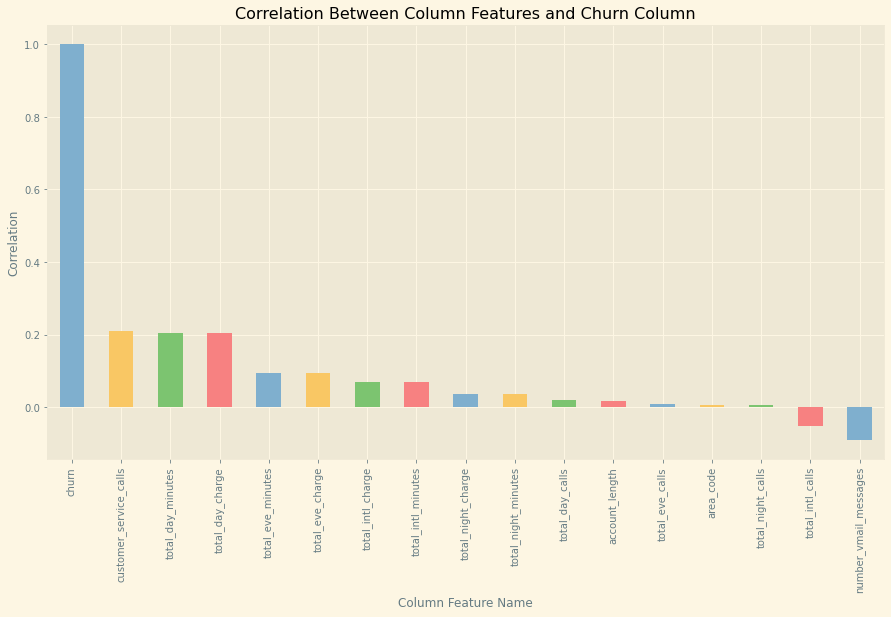

In [14]:
# Plot correlation between columns and churn
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(15,8))
    df_reg.corr()['churn'].sort_values(ascending = False)\
                            .plot(kind='bar',
                             color=['#7FAFCE','#F9C764','#7CC470', '#F78181'])
    plt.xlabel('Column Feature Name')
    plt.ylabel('Correlation')
    plt.title('Correlation Between Column Features and Churn Column')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>None of the column feature shows a strong correlation with the churn column.</li>
        <li>'Total intl calls' and 'number vmail messages' appear to be inversely correlated to the churn column.</li>
    </ul>
</div>

### Check Multicollinearity Among Independent Variables

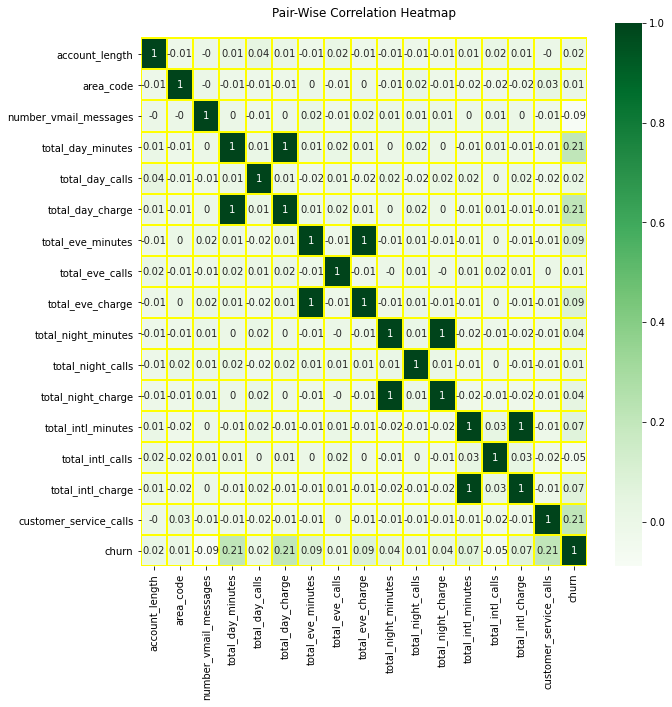

In [15]:
# A graphical representation of the pair-wise correlation using heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(round(df_reg.iloc[:,].corr(), 2), cmap='Greens',
            annot=True, linewidths=1, linecolor='yellow')
ax.set_ylim(len(df_reg.iloc[:,:].corr())-0, -0.5)
ax.set_title("Pair-Wise Correlation Heatmap")
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are a few independent features showing high correlation with one another.</li>
        <li>We will need to drop 'total day charge', 'total eve charge', 'total night charge' and 'total intl charge' so we don't violate the multicollinearity assumption for Logistic Regression.</li>
        <li>After dropping the 4 columns, we still have 16 columns available to meet the project requirements.
    </ul>
</div>

### Check Column Features by Churn

In [16]:
# Assign categorical and numerical column names to variables
cat_fea = df_reg.select_dtypes(object).columns
int_fea = df_reg.select_dtypes('int64').columns
flt_fea = df_reg.select_dtypes('float64').columns

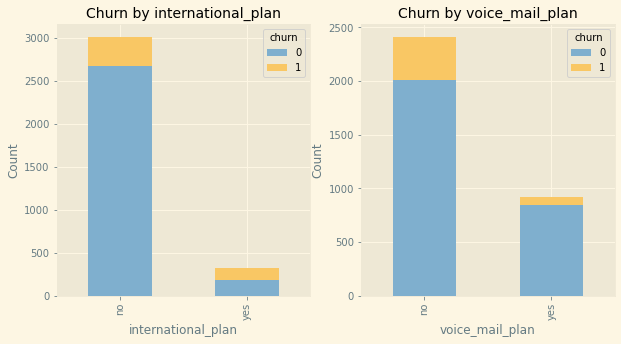

In [17]:
# Plot the churn rate by categorical features
with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    for xcol, ax in zip(['international_plan', 'voice_mail_plan'], axes):
        df_reg.groupby([xcol, 'churn']).size().unstack().plot(kind='bar',
                                                              stacked=True, ax=ax,
                                                              color=['#7FAFCE','#F9C764'])
        ax.set_ylabel('Count')
        ax.set_title(f'Churn by {xcol}', size=14)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rates are higher for customers with an international plan.  Almost half of the international plan subscribers cancel their services while only a smaller portion of the customers without a international plan cancel their accounts.</li>
        <li>Customers without the voice mail plan have substantial more true churn rates.</li>
    </ul>
</div>

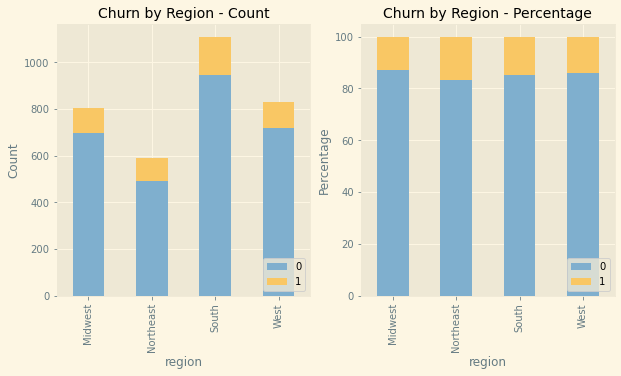

In [18]:
# Calculate Region churn rate percentage
st_churn = (df_reg.groupby('region')['churn'].value_counts(normalize=True)* 100).unstack()

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    df_reg.groupby(['region', 'churn']).size().unstack().plot(kind='bar',
                                                              stacked=True, ax=ax1,
                                                              color=['#7FAFCE','#F9C764'])
    ax1.set_title('Churn by Region - Count', size=14)
    ax1.set_ylabel('Count')
    ax1.legend(loc='lower right')
    st_churn.plot(kind='bar', stacked=True, ax=ax2, color=['#7FAFCE','#F9C764'])
    ax2.set_title('Churn by Region - Percentage', size=14)
    ax2.set_ylabel('Percentage')
    ax2.legend(loc='lower right')

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>We have more customers in the South region.</li>
        <li>Although Northeast makes up the smallest portion of the customer base, it has the highest customer churn.</li>
    </ul>
</div>

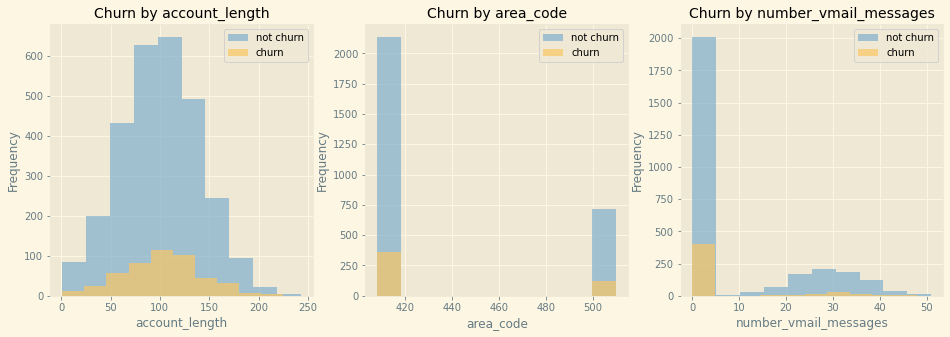

In [19]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (0,3))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True churn rate is at the highest when customers have the services for 3 months or so. We wonder this could be due to some type of promotional periods expiring and people are canceling their services.</li>
        <li>There are only 3 area codes for 51 states, which doesn't add up.  We will drop the column. </li>
        <li>Customers with very few voice mail messages or no voice mail because they don't have a voice mail plan, tend to have a higher true churn rate.</li>
    </ul>
</div>

In [20]:
# Drop the area code column
df_reg.drop(columns='area_code', axis=1, inplace=True)

# Verify drop
(df_reg.columns == 'area_code').sum()

0

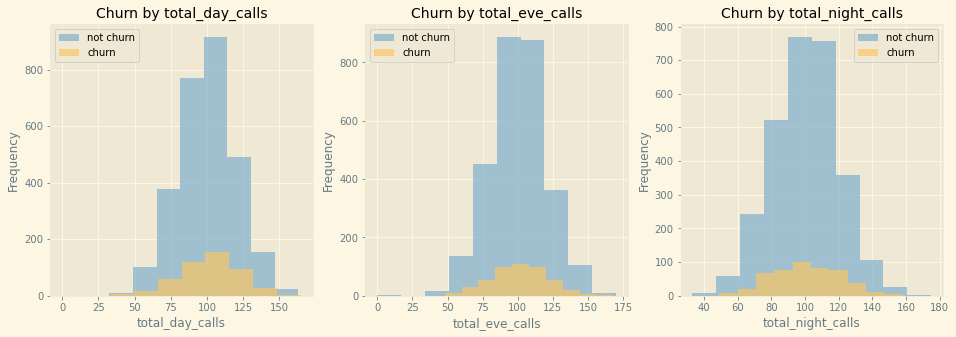

In [21]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (3,6))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Across all three plots, highest true churn rate can be found associated with customers making about 100 calls throughout day, eve and night call categories.</li>
    </ul>
</div>

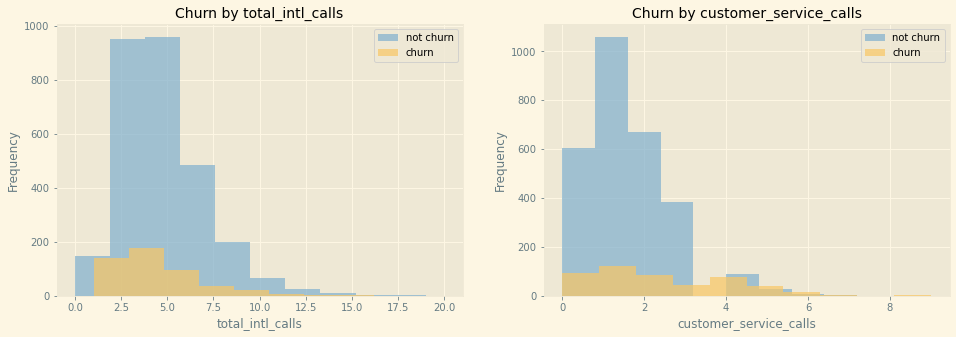

In [22]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, int_fea, (6,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The true churn rate by total international calls seems to be proportionally related to false churn rates.  Both display similar data distribution.</li>
        <li>The true churn rate is higher when the 'customer service calls' value is more than 3.
    </ul>
</div>

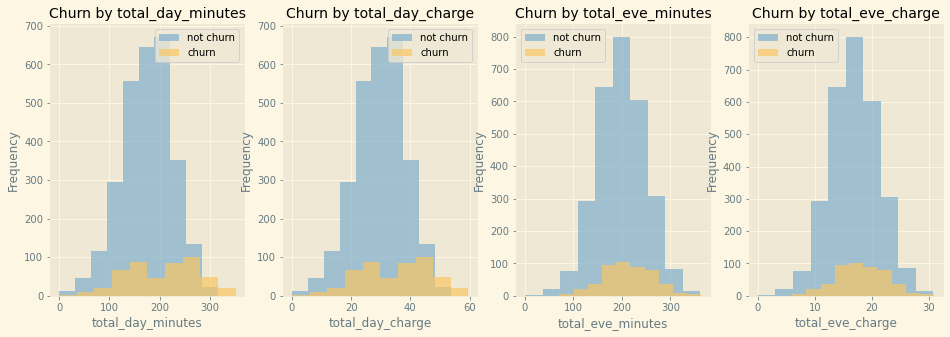

In [23]:
# Plot churn rate by numerical features
fea_churn_plot(df_reg, flt_fea, (0,4))

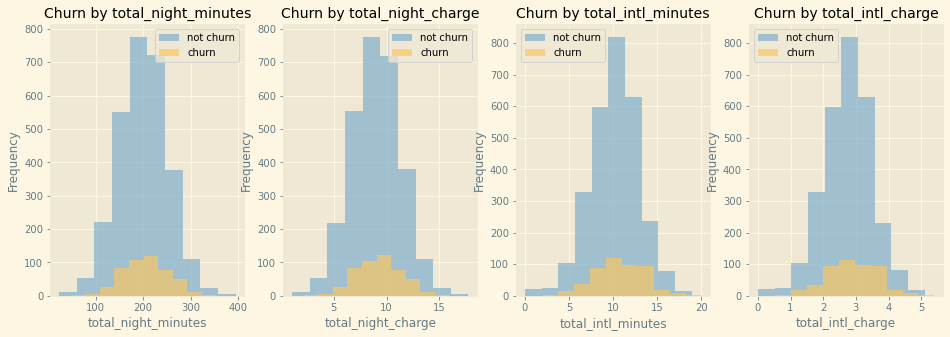

In [24]:
# Plot numerical churn rate by numerical features
fea_churn_plot(df_reg, flt_fea, (4,8))

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Features data seem to be normally distributed.</li>
        <li>Most true churn rates occur around the mean of the features.</li>
        <li>Total day minutes and total day charge upper bins do not contain any false churn rates.  We saw 100% true churn rates in the upper bins.</li>
    </ul>
</div>

In [25]:
# Drop 'total day charge', 'total eve charge', 'total night charge'
# and 'total intl charge' due to perfect correlation
col_to_drop = ['total_day_charge', 'total_eve_charge',
               'total_night_charge', 'total_intl_charge'] 

df_reg.drop(columns=col_to_drop, axis=1, inplace=True)

# Verify drop
len([col for col in df_reg.columns if 'charge' in col])

0

***
## Premodeling Preparations

### Create Train Test Split

In [26]:
# Separate labels and features
y = df_reg.churn.copy()
X = df_reg.drop(columns='churn', axis=1).copy()

# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36 )
print(X_train.shape, X_test.shape)

(2499, 14) (834, 14)


In [65]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [66]:
cat_names = X_train.select_dtypes(object).columns
cat_names

Index(['international_plan', 'voice_mail_plan', 'region'], dtype='object')

In [90]:
x_train_num = X_train.select_dtypes('number').reset_index(drop=True)
x_test_num = X_test.select_dtypes('number').reset_index(drop=True)

In [91]:
x_train_num.shape, x_test_num.shape

((2499, 11), (834, 11))

In [92]:
train_tmp = enc.fit_transform(X_train[cat_names])
test_tmp = enc.transform(X_test[cat_names])   

In [93]:
train_tmp.shape, test_tmp.shape

((2499, 8), (834, 8))

In [94]:
ohe_cat_names = enc.get_feature_names(cat_names)
ohe_cat_names

array(['international_plan_no', 'international_plan_yes',
       'voice_mail_plan_no', 'voice_mail_plan_yes', 'region_Midwest',
       'region_Northeast', 'region_South', 'region_West'], dtype=object)

In [95]:
train_ohe = pd.DataFrame(train_tmp, columns=[*ohe_cat_names])
test_ohe = pd.DataFrame(test_tmp, columns=[*ohe_cat_names])

In [96]:
train_ohe.shape, test_ohe.shape

((2499, 8), (834, 8))

In [97]:
x_train_num.shape, x_test_num.shape

((2499, 11), (834, 11))

In [98]:
t = pd.concat([test_ohe, x_train_num], axis=1)

In [99]:
t.shape

(2499, 19)

In [100]:
t.head()

international_plan_no  international_plan_yes  voice_mail_plan_no  \
0                    1.0                     0.0                 0.0   
1                    1.0                     0.0                 0.0   
2                    1.0                     0.0                 0.0   
3                    1.0                     0.0                 1.0   
4                    1.0                     0.0                 1.0   

   voice_mail_plan_yes  region_Midwest  region_Northeast  region_South  \
0                  1.0             0.0               0.0           0.0   
1                  1.0             0.0               1.0           0.0   
2                  1.0             1.0               0.0           0.0   
3                  0.0             0.0               0.0           1.0   
4                  0.0             0.0               0.0           0.0   

   region_West  account_length  number_vmail_messages  total_day_minutes  \
0          1.0              31                      0              177.3   
1          0.0             118                     36              294.9   
2          0.0             124                      0              244.6   
3          0.0              65                      0              129.1   
4          1.0              97                      0              146.0   

   total_day_calls  total_eve_minutes  total_eve_calls  total_night_minutes  \
0              129              152.8              105                162.9   
1              106              165.7              115                189.2   
2               89              188.8               80                206.0   
3              137              228.5               83                208.8   
4              121              203.0              141                151.8   

   total_night_calls  total_intl_minutes  total_intl_calls  \
0                 92                 5.1                 2   
1                 63                 9.8                 5   
2                114                11.3                 4   
3                111                12.7                 6   
4                120                13.3                 2   

   customer_service_calls  
0                       0  
1                       3  
2                       1  
3                       4  
4                       1

### One Hot Encoding

In [27]:
# Perform One Hot Encoding
X_train_ohe, X_test_ohe = exec_ohe(X_train, X_test)

In [28]:
# Preview data
X_train_ohe.head()

international_plan_no  international_plan_yes  voice_mail_plan_no  \
0                    1.0                     0.0                 1.0   
1                    1.0                     0.0                 0.0   
2                    0.0                     1.0                 1.0   
3                    1.0                     0.0                 1.0   
4                    1.0                     0.0                 1.0   

   voice_mail_plan_yes  region_Midwest  region_Northeast  region_South  \
0                  0.0             0.0               0.0           0.0   
1                  1.0             0.0               0.0           0.0   
2                  0.0             0.0               0.0           0.0   
3                  0.0             1.0               0.0           0.0   
4                  0.0             0.0               0.0           0.0   

   region_West  account_length  number_vmail_messages  total_day_minutes  \
0          1.0              31                      0              177.3   
1          1.0             118                     36              294.9   
2          1.0             124                      0              244.6   
3          0.0              65                      0              129.1   
4          1.0              97                      0              146.0   

   total_day_calls  total_eve_minutes  total_eve_calls  total_night_minutes  \
0              129              152.8              105                162.9   
1              106              165.7              115                189.2   
2               89              188.8               80                206.0   
3              137              228.5               83                208.8   
4              121              203.0              141                151.8   

   total_night_calls  total_intl_minutes  total_intl_calls  \
0                 92                 5.1                 2   
1                 63                 9.8                 5   
2                114                11.3                 4   
3                111                12.7                 6   
4                120                13.3                 2   

   customer_service_calls  
0                       0  
1                       3  
2                       1  
3                       4  
4                       1

In [29]:
# Preview data
X_test_ohe.head()

international_plan_no  international_plan_yes  voice_mail_plan_no  \
0                    1.0                     0.0                 0.0   
1                    1.0                     0.0                 0.0   
2                    1.0                     0.0                 0.0   
3                    1.0                     0.0                 1.0   
4                    1.0                     0.0                 1.0   

   voice_mail_plan_yes  region_Midwest  region_Northeast  region_South  \
0                  1.0             0.0               0.0           0.0   
1                  1.0             0.0               1.0           0.0   
2                  1.0             1.0               0.0           0.0   
3                  0.0             0.0               0.0           1.0   
4                  0.0             0.0               0.0           0.0   

   region_West  account_length  number_vmail_messages  total_day_minutes  \
0          1.0              47                     28              172.9   
1          0.0             146                     23              149.6   
2          0.0             131                     36              214.2   
3          0.0              62                      0              186.8   
4          1.0              60                      0              221.1   

   total_day_calls  total_eve_minutes  total_eve_calls  total_night_minutes  \
0              109              137.6               94                203.8   
1               96              239.8              124                293.5   
2              115              161.7              117                264.7   
3               94              207.6               92                195.0   
4              106              178.6               48                202.7   

   total_night_calls  total_intl_minutes  total_intl_calls  \
0                109                 8.3                 6   
1                135                 7.4                 4   
2                102                 9.5                 4   
3                 98                 8.8                 4   
4                 90                 7.4                 3   

   customer_service_calls  
0                       1  
1                       2  
2                       3  
3                       3  
4                       1

In [33]:
# # One hot encoding training data
# X_train_ohe = pd_ohe(X_train)

# # Preview data
# X_train_ohe.head()

In [32]:
# # One hot encoding test data
# X_test_ohe = pd_ohe(X_test)

# # Preview data
# X_test_ohe.head()

***
## Baseline Model

### Fit Model

In [30]:
# Define list of classifiers to feed to pipeline
clfs = [LogisticRegression(random_state=36), KNeighborsClassifier(),
        RandomForestClassifier(random_state=36), xgb.XGBClassifier(random_state=36)]

In [31]:
# Assign train and test dataset to list to pass to function
df_baseline = [X_train_ohe, y_train, X_test_ohe, y_test]

### Plot Confusion Matrix

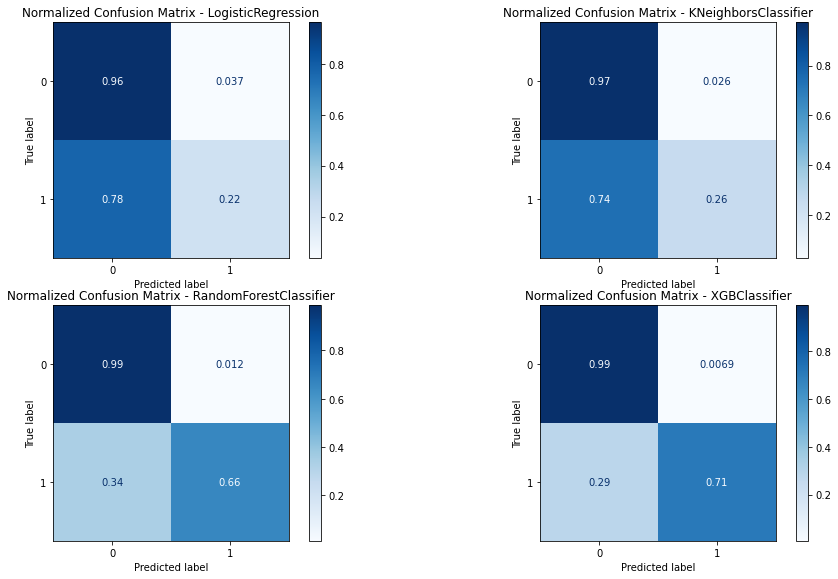

In [33]:
# Fit model, generate classifcation report and plot confusion matrix
# base_mdl_clf_rpt, clf_dict = fit_eval_clf(clfs, X_train_ohe, y_train, X_test_ohe, y_test)
base_mdl_clf_rpt, clf_dict = fit_eval_clf(clfs, df_baseline)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>All 4 classifiers did very well in predicting true negative, i.e. false churn rate.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>XGBoost performed remarkably in predicting true positive as was Random Forest.  Can't say the same for Logistic Regression and K-Nearest Neighbors (KNN).</li>
        </ul>
</div>

### Plot Comparison Chart

In [34]:
# Display model classification report
base_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.888747  0.962604  0.924202  722.000000   
Churn                  0.480769  0.223214  0.304878  112.000000   
accuracy               0.863309  0.863309  0.863309    0.863309   
macro avg              0.684758  0.592909  0.614540  834.000000   
weighted avg           0.833958  0.863309  0.841032  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.894402  0.973684  0.932361  722.000000   
Churn                    0.604167  0.258929  0.362500  112.000000   
accuracy                 0.877698  0.877698  0.877698    0.877698   
macro avg                0.749284  0.616306  0.647430  834.000000   
weighted avg             0.855426  0.877698  0.855833  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.949401  0.987535  0.968092  722.000000   
Churn                      0.891566  0.660714  0.758974  112.000000   
accuracy                   0.943645  0.943645  0.943645    0.943645   
macro avg                  0.920484  0.824124  0.863533  834.000000   
weighted avg               0.941634  0.943645  0.940009  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.957276  0.993075  0.974847  722.000000  
Churn             0.941176  0.714286  0.812183  112.000000  
accuracy          0.955635  0.955635  0.955635    0.955635  
macro avg         0.949226  0.853680  0.893515  834.000000  
weighted avg      0.955114  0.955635  0.953002  834.000000

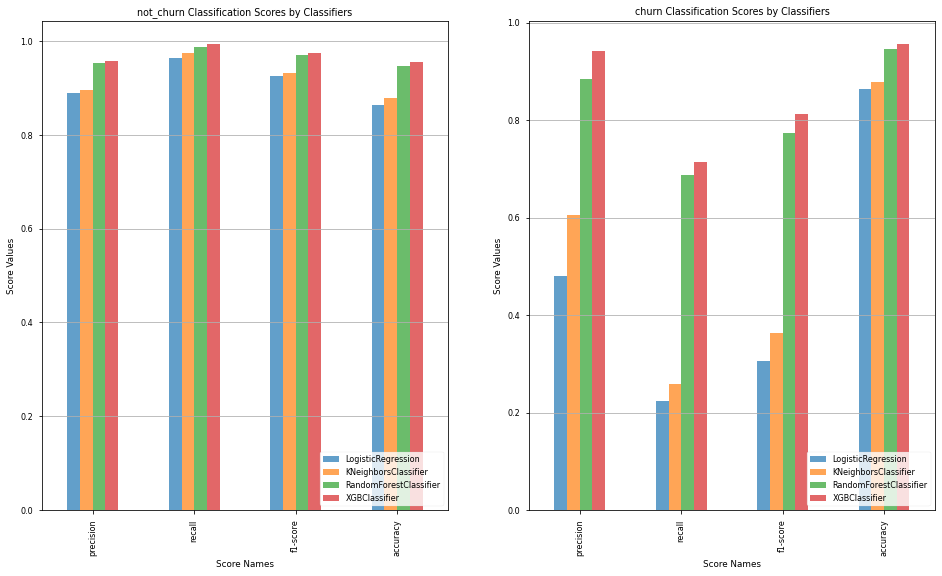

In [33]:
# Plot comparison chart
plot_clf_rpt(base_mdl_clf_rpt, clf_dict)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Across the 4 scores, Logistic Regression fared the worst.  XGBoost came out on top among the 4 classifiers.</li>
            <li>All models reported an impressive recall score of over 90%.</li>
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Logistic Regression's performance pale compared to the other three classifiers.  Again, XGBoost came out on top as the best model.</li>
            <li>Recall and f1_score values were low which might be caused by the class imbalance issue.</li>
        </ul>
</div>

***
## Fine Tune Models

### Address Class Imbalance Problem

In [34]:
# Use SMOTE since we don't have a lot of features and data, computational issues are mininum
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train_ohe, y_train)

# Check new train dataset
print(pd.Series(y_train_smote.value_counts()))            

1    2128
0    2128
Name: churn, dtype: int64


### Fit Model with Resample Data

In [35]:
# Assign update X, y data sets to variable
df_smote = [X_train_smote, y_train_smote, X_test_ohe, y_test]

In [36]:
# Fit model, generate classification report and plot confusion matrix
smote_mdl_clf_rpt, smote_clf_dict = fit_eval_clf(clfs, df_smote, disp_cm=False)

In [37]:
# Display classificaiton report
smote_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.917492  0.770083  0.837349  722.000000   
Churn                  0.271930  0.553571  0.364706  112.000000   
accuracy               0.741007  0.741007  0.741007    0.741007   
macro avg              0.594711  0.661827  0.601028  834.000000   
weighted avg           0.830798  0.741007  0.773877  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.896890  0.759003  0.822206  722.000000   
Churn                    0.219731  0.437500  0.292537  112.000000   
accuracy                 0.715827  0.715827  0.715827    0.715827   
macro avg                0.558311  0.598251  0.557371  834.000000   
weighted avg             0.805953  0.715827  0.751075  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.938776  0.955679  0.947152  722.000000   
Churn                      0.676768  0.598214  0.635071  112.000000   
accuracy                   0.907674  0.907674  0.907674    0.907674   
macro avg                  0.807772  0.776946  0.791111  834.000000   
weighted avg               0.903590  0.907674  0.905242  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.954220  0.923823  0.938776  722.000000  
Churn             0.592593  0.714286  0.647773  112.000000  
accuracy          0.895683  0.895683  0.895683    0.895683  
macro avg         0.773406  0.819054  0.793274  834.000000  
weighted avg      0.905656  0.895683  0.899696  834.000000

### Plot Performance Gain/Loss SMOTE vs Base

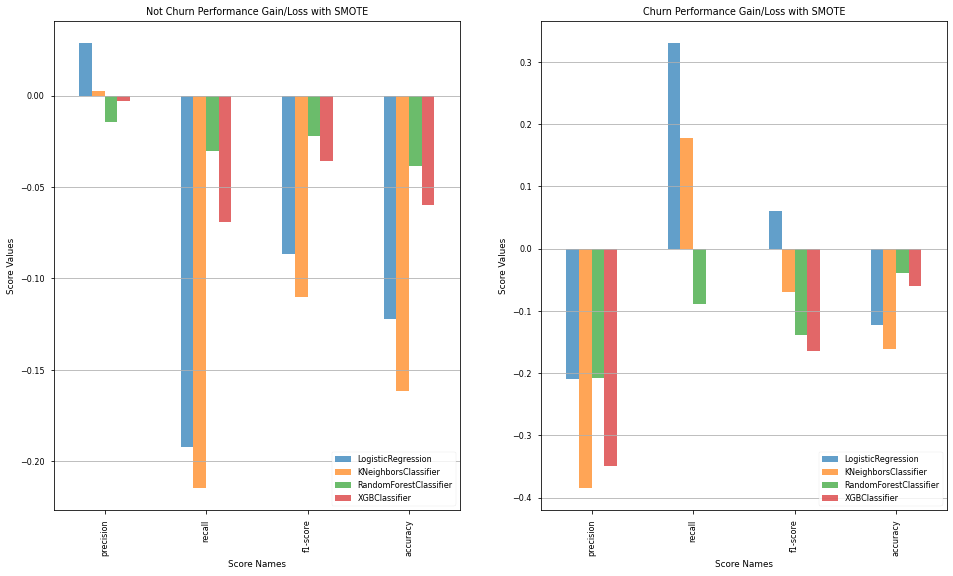

In [38]:
# Plot performance gain/loss between model with SMOTE treatment and without
plot_gain_loss(smote_mdl_clf_rpt, base_mdl_clf_rpt, {'f_churn': 'Not Churn', 't_churn': 'Churn'})

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>After resampling the training data with SMOTE, there is slight decrease in all the scores among the models, except Logistic Regression and KNN models, showing small gain in the precision scores.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>The Logistic Regression and the KNN models seem to benefit the most from the SMOTE sampling, both showing slight gain in recall score.</li>
        </ul>
</div>

### Grid Search Hyperparameters

In [39]:
# Establish GridSearch parameter grids for the models

# fit_intercept, add bias if true.  Small C = stronger regularization
# Since sample data are quite small and doesn't involve multi class, set solver to liblinear
# liblinear only works with penalty 'l1', omit 'l2' from parameter
lr_params = {'lr__fit_intercept': [True, False],
             'lr__C': [0.001,0.01,0.1,1,10,100,1000],
             'lr__penalty': ['l1'],
             'lr__solver': ['liblinear']}

# A lower n_neighbors = more complex model.  Distance in weight means closer neighbors
# of a query point will have a greater influnce.
knn_params = {'knn__n_neighbors': list(range(1, 33, 2)),
              'knn__metric': ['euclidean', 'minkowski'],
              'knn__weights': ['uniform', 'distance']}

# n_estimators = number of trees in the foreset; max_features = max number of features
# considered for splitting a node; max_dept = max number of levels in each decision tree
# min_samples_leaf = min number of data points allowed in a leaf node
rf_params = {'rf__n_estimators': [5, 30, 100, 170, 250],
             'rf__max_features': ['auto', 'sqrt', 'log2'],
             'rf__max_depth' : [4,5,6,7,8],
             'rf__min_samples_leaf': [3, 5, 7]}

# min_child_weight = min_sample_leaf; 
xg_params = {'xg__n_estimators': [5, 30, 100, 170, 250],
             'xg__max_depth': range(3,10,2),
             'xg__min_child_weight': list(range(1,6,2)),
             'xg__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# Set up functions parameters
alg_dict = {'lr': LogisticRegression(max_iter=10000, random_state=36), 'knn': KNeighborsClassifier(),
            'rf': RandomForestClassifier(random_state=36), 'xg': xgb.XGBClassifier(random_state=36)}

mdl_params = {'lr_grd_sch': lr_params, 'knn_grd_sch': knn_params,
              'rf_grd_sch': rf_params , 'xg_grd_sch': xg_params}

In [40]:
# Run gridsearchcv.  Cell takes 22 min.  Could not set n_jobs=-1 as it messed up the timer.
df_grdsch_mdl = fit_evl_grdsch(alg_dict, mdl_params, df_smote)

running gridsearch for lr
total elapsed time 00:00:01
running gridsearch for knn
total elapsed time 00:00:33
running gridsearch for rf
total elapsed time 00:07:36
running gridsearch for xg
total elapsed time 00:13:13


In [41]:
# View Results
df_grdsch_mdl

no_model exec_time                                        best_params  \
lr         14  00:00:01  {'lr__C': 1000, 'lr__fit_intercept': False, 'l...   
knn        64  00:00:33  {'knn__metric': 'euclidean', 'knn__n_neighbors...   
rf        225  00:07:36  {'rf__max_depth': 8, 'rf__max_features': 'auto...   
xg        360  00:13:13  {'xg__learning_rate': 0.3, 'xg__max_depth': 9,...   

                                              best_est  best_score  
lr   (StandardScaler(), LogisticRegression(C=1000, ...    0.860826  
knn  (StandardScaler(), KNeighborsClassifier(metric...    0.948014  
rf   (StandardScaler(), (DecisionTreeClassifier(max...    0.950097  
xg   (StandardScaler(), XGBClassifier(learning_rate...    0.983647

### Fit Models with New Parameters

In [42]:
# Define list of classifiers to feed to pipeline
grdsch_clfs = []
for i in range(len(df_grdsch_mdl.best_est.values)):
    est = df_grdsch_mdl.best_est.values[i][-1]
    print(est)
    grdsch_clfs.append(est)

LogisticRegression(C=1000, fit_intercept=False, max_iter=10000, penalty='l1',
                   random_state=36, solver='liblinear')
KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')
RandomForestClassifier(max_depth=8, min_samples_leaf=3, n_estimators=250,
                       random_state=36)
XGBClassifier(learning_rate=0.3, max_depth=9, n_estimators=250, random_state=36)


### Plot Confusion Matrix

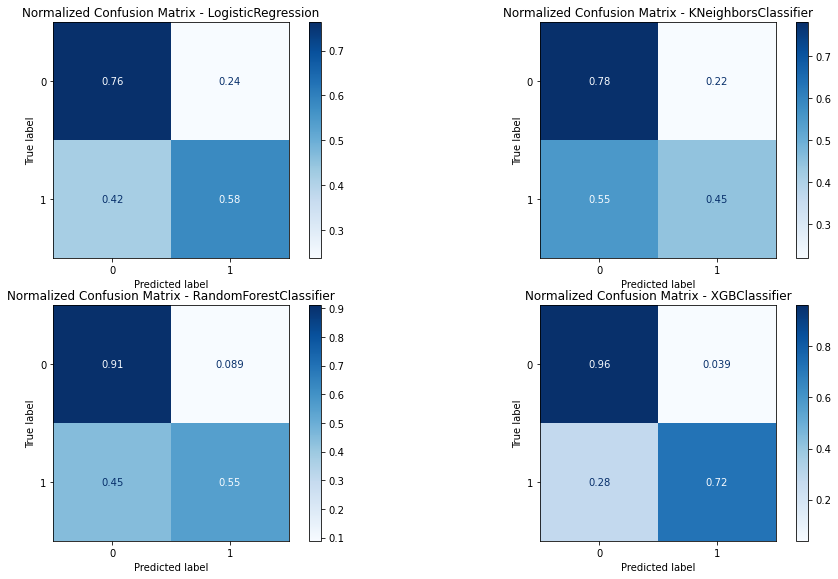

In [43]:
# Fit model, generate classification report and plot confusion matrix with best estimators
grdsch_mdl_clf_rpt, grdsch_clf_dict = fit_eval_clf(grdsch_clfs, df_smote)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>True positive rates went up for Logistic Regression and KNN while they had gone lower for Random Forest and XGBoost.</li>
        <li>We will get a better picture when we plot the performance gain/log figure.</li>
    </ul>
</div>

### Plot Comparison Chart

In [44]:
# View classification report
grdsch_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.921405  0.763158  0.834848  722.000000   
Churn                  0.275424  0.580357  0.373563  112.000000   
accuracy               0.738609  0.738609  0.738609    0.738609   
macro avg              0.598414  0.671758  0.604206  834.000000   
weighted avg           0.834654  0.738609  0.772901  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.900800  0.779778  0.835932  722.000000   
Churn                    0.239234  0.446429  0.311526  112.000000   
accuracy                 0.735012  0.735012  0.735012    0.735012   
macro avg                0.570017  0.613103  0.573729  834.000000   
weighted avg             0.811957  0.735012  0.765508  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.929379  0.911357  0.920280  722.000000   
Churn                      0.492063  0.553571  0.521008  112.000000   
accuracy                   0.863309  0.863309  0.863309    0.863309   
macro avg                  0.710721  0.732464  0.720644  834.000000   
weighted avg               0.870650  0.863309  0.866661  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.957241  0.961219  0.959226  722.000000  
Churn             0.743119  0.723214  0.733032  112.000000  
accuracy          0.929257  0.929257  0.929257    0.929257  
macro avg         0.850180  0.842217  0.846129  834.000000  
weighted avg      0.928486  0.929257  0.928850  834.000000

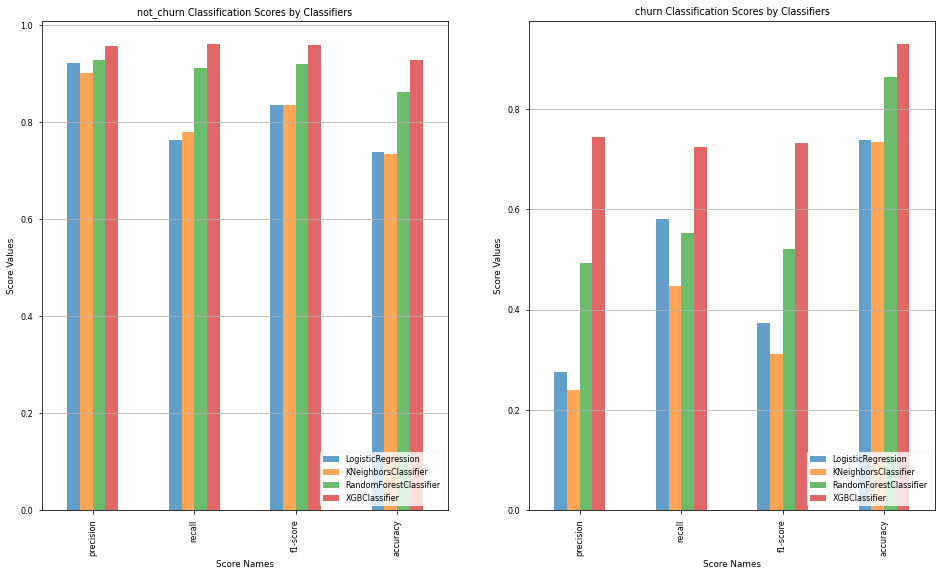

In [45]:
# Plot comparison chart
plot_clf_rpt(grdsch_mdl_clf_rpt, grdsch_clf_dict)

### Plot Performance Gain/Loss Tuned vs Base

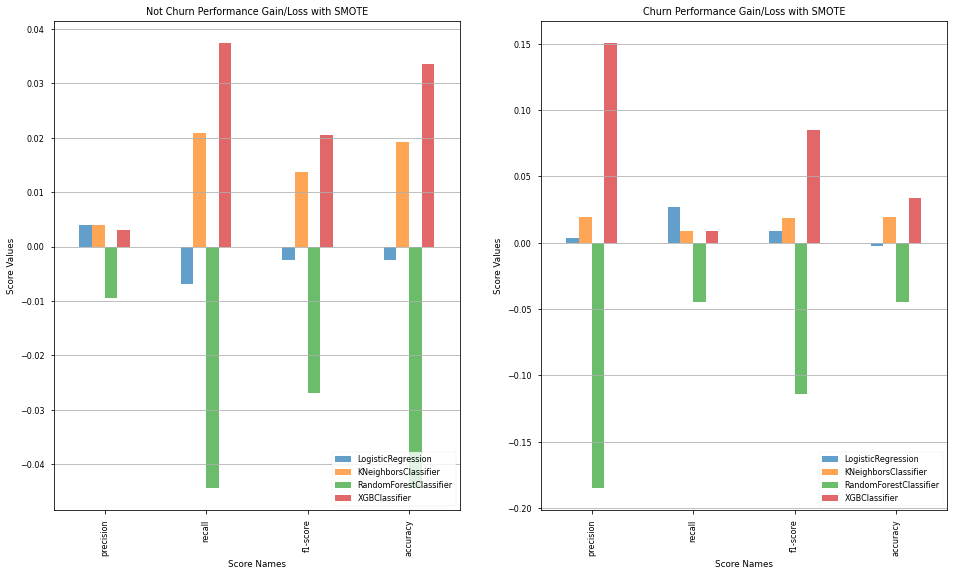

In [46]:
# Plot Performance Gain/Loss chart
plot_gain_loss(grdsch_mdl_clf_rpt, smote_mdl_clf_rpt, {'f_churn': 'Not Churn', 't_churn': 'Churn'})

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>KNN and XGBoost showed improvement in performance after the tuned parameters.  Especially in the case of XGBoost.  Random Forest lost out the most from the tuned parameters.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Similar behaviors can be observed here with KNN and XGBoost benefited from the tuned parameters.  However, there is a drop in recall score for XGBoost from baseline of .71 to tuned model of .66</li>
    </ul>
    <p>--- Conclusion ---</p>
        <ul>
            <li>Nonetheless, based on the classification report charts, XGBoost is clearly the superior model.  We will use it for the next step, model evaluation. </li>
        </ul>
</div>

***
## Model Evaluation

### Model Validation

In [47]:
# Compare train, test accuracy score
mdl_a_xg_clf = xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=250)

y_test_pred, y_train_acc, y_test_acc = mdl_validation('xgb', mdl_a_xg_clf, df_smote)

print(f'\n***** Train Accuracy: {y_train_acc * 100}%. ' +
      f'Test Accuracy:{round(y_test_acc * 100,2)}% *****')


***** Train Accuracy: 100.0%. Test Accuracy:92.69% *****


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The test Accuracy score is more than 5% lower than the training scores, which might suggest an issue with overfitting.</li>
    </ul>
</div>

### Plot ROC Curve


***** AUC Score: 83.71% *****


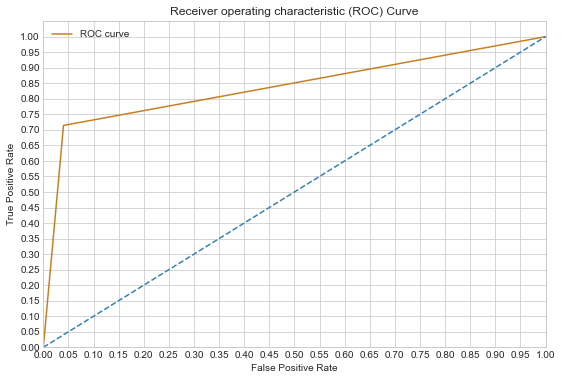

In [48]:
# Plot ROC curve
plot_roc_cur(y_test, y_test_pred, sec=None)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Our model produces a Area under the Curve (AUC) score of 0.813.  In other words, the model correctly distinguished between 'Churn' and 'Not Churn' at approximately 81% of the time.</li>
        <li>We will refer to this model as Model A.</li>
    </ul>
</div>

***
## Alternate Model - Model B

In Model A we grouped States by region for the sake of simplicity.  Perhaps, the geographic data might provide additional insights as to why and where the churn happen. Here we will construct another model without grouping the States by Region. It will be referred to as model B.

## Model B - Import Data

In [49]:
# Create a new daaframe without the States grouping
df_alt = df.copy()

In [50]:
# View data
df_alt.head()

state  account length  area code international plan voice mail plan  \
0    KS             128        415                 no             yes   
1    OH             107        415                 no             yes   
2    NJ             137        415                 no              no   
3    OH              84        408                yes              no   
4    OK              75        415                yes              no   

   number vmail messages  total day minutes  total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total day charge  total eve minutes  total eve calls  total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1      0  
1                       1      0  
2                       0      0  
3                       2      0  
4                       3      0

## Clean and Scrub Data

In [51]:
# Drop the area code column
df_alt.drop(columns='area code', axis=1, inplace=True)

# Verify drop
(df_alt.columns == 'area code').sum()

0

In [52]:
# Drop 'total day charge', 'total eve charge', 'total night charge'
# and 'total intl charge' due to perfect correlation
col_to_drop = ['total day charge', 'total eve charge',
               'total night charge', 'total intl charge'] 

df_alt.drop(columns=col_to_drop, axis=1, inplace=True)

# Verify drop
len([col for col in df_alt.columns if 'charge' in col])

0

## Explore Data

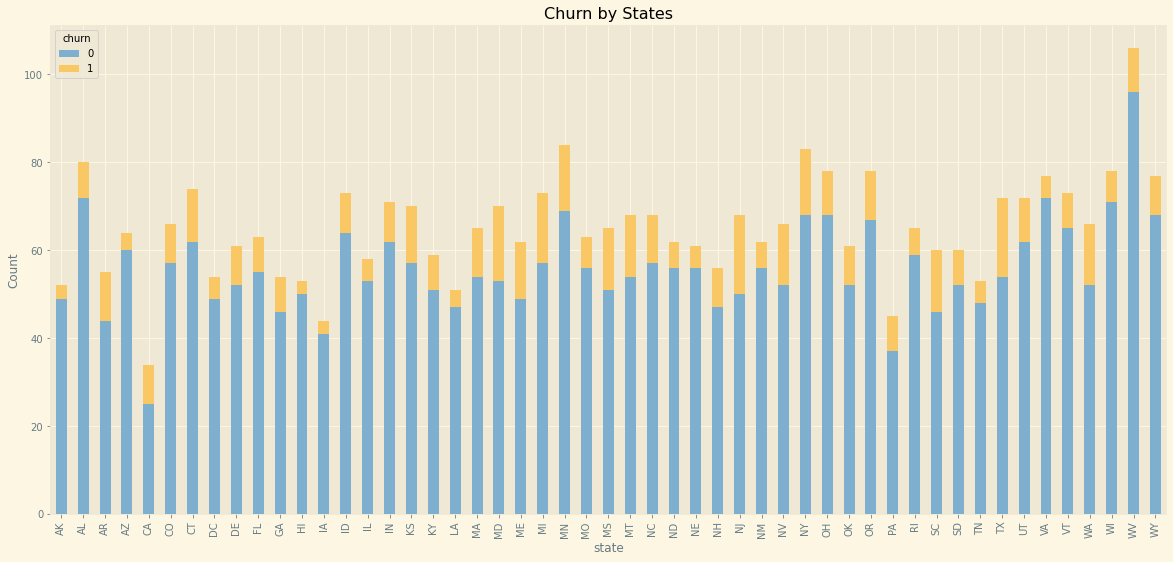

In [53]:
# Plot the churn rate by States
with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(figsize=(20,9))
    df_alt.groupby(['state', 'churn']).size().unstack().plot(kind='bar',
                                                             stacked=True,
                                                             color=['#7FAFCE','#F9C764'],
                                                             ax=axes)
    plt.ylabel('Count')
    plt.title('Churn by States')
    plt.show()

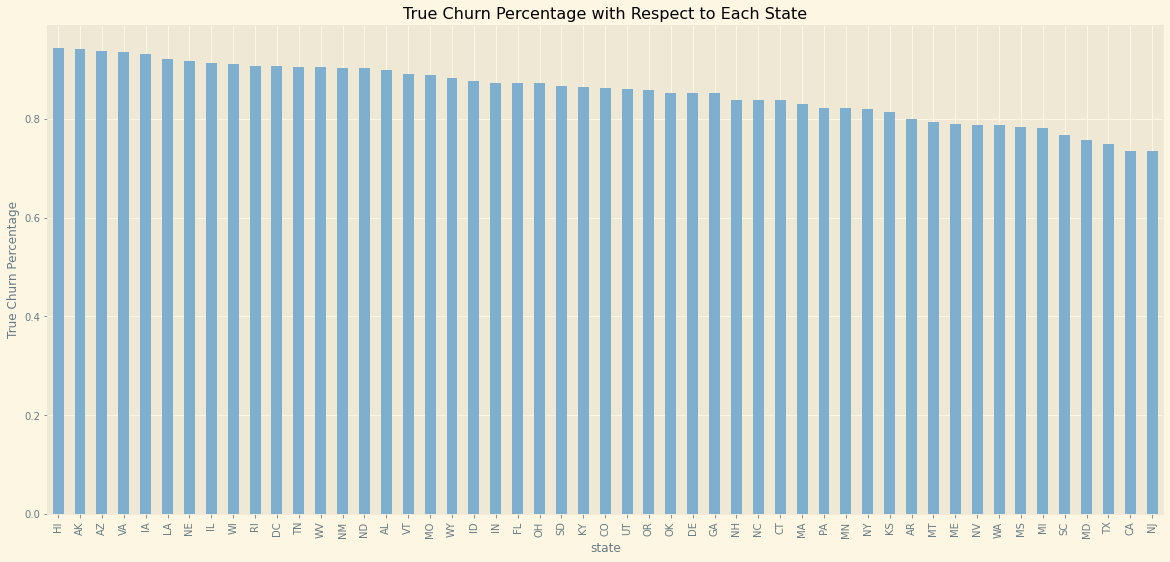

In [54]:
# Plot the true churn rate percentage per State
state_true_c = (df_alt.groupby('state')['churn'].
                value_counts(normalize=True).unstack()[0].sort_values(ascending=False))

with plt.style.context('Solarize_Light2'):
    fig, axes = plt.subplots(figsize=(20,9))
    state_true_c.plot(kind='bar', stacked=True, color='#7FAFCE', ax=axes)
    plt.ylabel('True Churn Percentage')
    plt.title('True Churn Percentage with Respect to Each State')
    plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The top 5 Sates with the highest Churn rates are HI, AK, AZ, VA and IA.</li>
    </ul>
</div>

***
## Model B - Premodeling Preparations

### Create Train Test Split

In [55]:
# Separate labels and features
y_b = df_alt.churn.copy()
X_b = df_alt.drop(columns='churn', axis=1).copy()


X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b,
                                                            y_b,
                                                            test_size=0.25,
                                                            random_state=36 )
print(X_b_train.shape, X_b_test.shape)

(2499, 14) (834, 14)


### One Hot Encoding

In [56]:
# One hot encoding test data
X_b_train_ohe = pd_ohe(X_b_train)

# Preview data
X_b_train_ohe.head()

state_AL  state_AR  state_AZ  state_CA  state_CO  state_CT  state_DC  \
996          0         0         0         0         0         0         0   
1396         0         0         0         0         0         0         0   
2421         0         0         0         0         1         0         0   
642          0         0         0         0         0         0         0   
2191         0         0         0         0         0         0         0   

      state_DE  state_FL  state_GA  ...  number vmail messages  \
996          0         0         0  ...                      0   
1396         0         0         0  ...                     27   
2421         0         0         0  ...                      0   
642          0         0         0  ...                      0   
2191         0         0         0  ...                      0   

      total day minutes  total day calls  total eve minutes  total eve calls  \
996               116.1              101              201.8               99   
1396              188.9              124              160.9              102   
2421              197.8               66              133.9              119   
642               195.0               92              210.5               83   
2191               90.6              130              170.6              100   

      total night minutes  total night calls  total intl minutes  \
996                 181.9                103                11.6   
1396                197.7                100                11.5   
2421                177.3                 94                10.9   
642                 180.6                 92                11.0   
2191                137.4                 74                 5.4   

      total intl calls  customer service calls  
996                  5                       0  
1396                 5                       4  
2421                 3                       4  
642                 13                       0  
2191                 9                       1  

[5 rows x 63 columns]

In [57]:
# One hot encoding test data
X_b_test_ohe = pd_ohe(X_b_test)

# Preview data
X_b_test_ohe.head()

state_AL  state_AR  state_AZ  state_CA  state_CO  state_CT  state_DC  \
1038         0         0         0         1         0         0         0   
3241         0         0         0         0         0         0         0   
1523         0         0         0         0         0         0         0   
532          0         0         0         0         0         0         0   
1013         0         0         0         0         0         0         0   

      state_DE  state_FL  state_GA  ...  number vmail messages  \
1038         0         0         0  ...                      0   
3241         0         0         0  ...                      0   
1523         0         0         0  ...                      0   
532          0         0         0  ...                     38   
1013         0         0         0  ...                      0   

      total day minutes  total day calls  total eve minutes  total eve calls  \
1038              111.9               92              114.0              143   
3241              248.7              118              172.3               73   
1523              115.1               89              196.8              111   
532               213.7               61              253.0              104   
1013              156.2               93              193.0               54   

      total night minutes  total night calls  total intl minutes  \
1038                146.8                 79                14.1   
3241                191.9                 87                11.3   
1523                212.4                 98                11.4   
532                 207.7                 73                10.7   
1013                222.7                 94                13.1   

      total intl calls  customer service calls  
1038                 3                       5  
3241                 2                       1  
1523                 3                       2  
532                  5                       2  
1013                 5                       1  

[5 rows x 63 columns]

## Model B - Baseline Model

### Fit Model

In [58]:
# Assign X, y train, test to variable
df_b_baseline = [X_b_train_ohe, y_b_train, X_b_test_ohe, y_b_test]

In [59]:
# Define list of classifiers to feed to pipeline
b_clfs = [LogisticRegression(random_state=36), KNeighborsClassifier(),
        RandomForestClassifier(random_state=36), xgb.XGBClassifier(random_state=36)]

### Plot Confusion Matrix

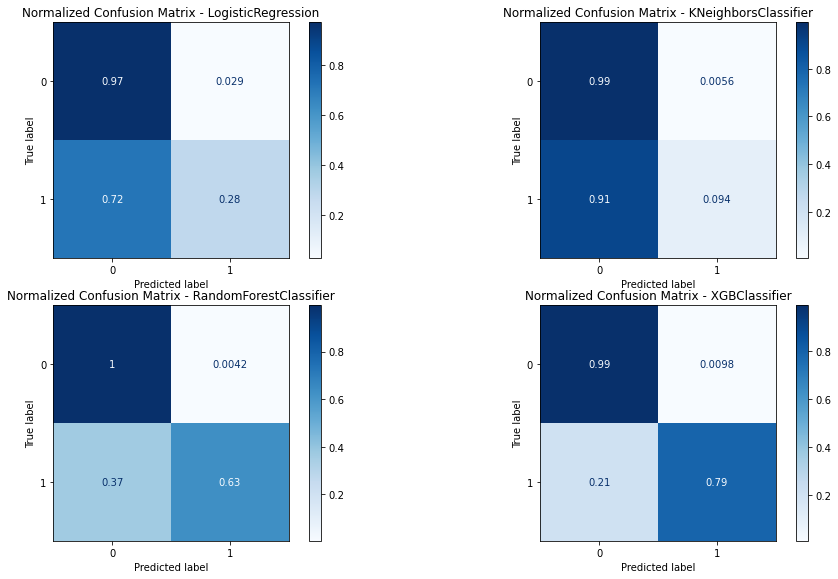

In [60]:
# Fit model, generate classifcation report and plot confusion matrix
b_base_mdl_clf_rpt, b_clf_dict = fit_eval_clf(b_clfs, df_b_baseline)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>XGBoost in this model produced a higher recall score, 0.79 vs 0.71 in Model A. KNN did the worst with only 0.094 and a decrease compared to model A's score of 0.26.</li>
    </ul>
</div>

### Plot Comparison Chart

In [61]:
# Display model classification report
b_base_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.892308  0.970711  0.929860  717.000000   
Churn                  0.611111  0.282051  0.385965  117.000000   
accuracy               0.874101  0.874101  0.874101    0.874101   
macro avg              0.751709  0.626381  0.657912  834.000000   
weighted avg           0.852859  0.874101  0.853558  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.870574  0.994421  0.928385  717.000000   
Churn                    0.733333  0.094017  0.166667  117.000000   
accuracy                 0.868106  0.868106  0.868106    0.868106   
macro avg                0.801954  0.544219  0.547526  834.000000   
weighted avg             0.851321  0.868106  0.821526  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.943197  0.995816  0.968792  717.000000   
Churn                      0.961039  0.632479  0.762887  117.000000   
accuracy                   0.944844  0.944844  0.944844    0.944844   
macro avg                  0.952118  0.814147  0.865839  834.000000   
weighted avg               0.945700  0.944844  0.939906  834.000000   

             XGBClassifier                                 
                 precision    recall  f1-score    support  
Not Churn         0.967302  0.990237  0.978635  717.00000  
Churn             0.930000  0.794872  0.857143  117.00000  
accuracy          0.962830  0.962830  0.962830    0.96283  
macro avg         0.948651  0.892554  0.917889  834.00000  
weighted avg      0.962069  0.962830  0.961592  834.00000

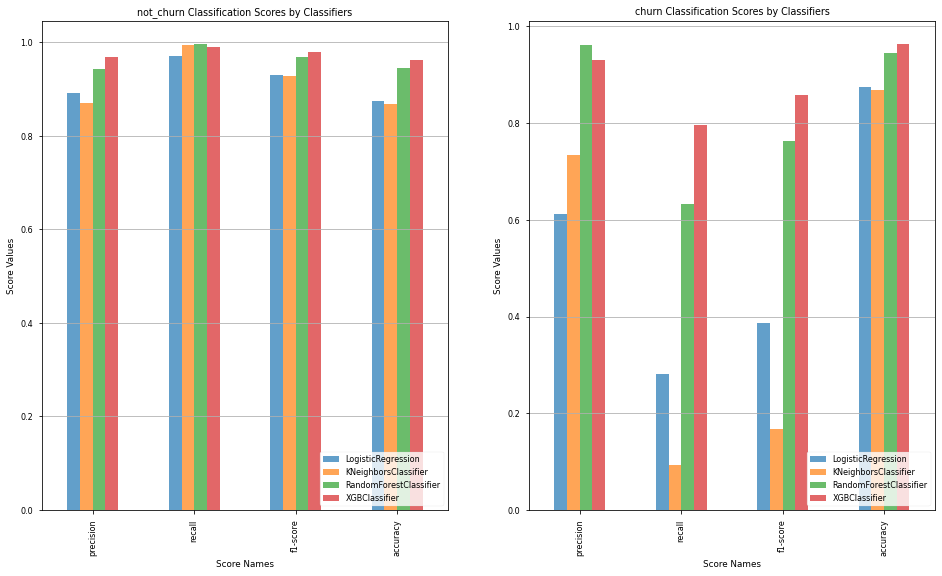

In [62]:
# Plot comparison chart
plot_clf_rpt(b_base_mdl_clf_rpt, b_clf_dict)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>All four model did pretty well in this area.  Again XGBoost outperformed the other three in most scores.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>KNN have a very low recall and f1_score so is Logistic Regression.  XGBoost led the pack in this baseline model evaluation.</li>
        </ul>
</div>

***
## Model B - Fine Tune Model

### Address Class Imbalance Problems

In [63]:
# Use SMOTE since we don't have a lot of features and data, computational issues are mininum
smote = SMOTE()
X_b_train_smote, y_b_train_smote = smote.fit_sample(X_b_train_ohe,
                                                    y_b_train)

# Check new train dataset
print(pd.Series(y_b_train_smote.value_counts()))

1    2133
0    2133
Name: churn, dtype: int64


### Model B - Grid Search Hyperparameters

In [64]:
# Establish GridSearch parameter grids for the models

# fit_intercept, add bias if true.  Small C = stronger regularization
# Since sample data are quite small and doesn't involve multi class, set solver to liblinear
# liblinear only works with penalty 'l1', omit 'l2' from parameter
lr_params = {'lr__fit_intercept': [True, False],
             'lr__C': [0.001,0.01,0.1,1,10,100,1000],
             'lr__penalty': ['l1'],
             'lr__solver': ['liblinear']}

# A lower n_neighbors = more complex model.  Distance in weight means closer neighbors
# of a query point will have a greater influnce.
knn_params = {'knn__n_neighbors': list(range(1, 33, 2)),
              'knn__metric': ['euclidean', 'minkowski'],
              'knn__weights': ['uniform', 'distance']}

# n_estimators = number of trees in the foreset; max_features = max number of features
# considered for splitting a node; max_dept = max number of levels in each decision tree
# min_samples_leaf = min number of data points allowed in a leaf node
rf_params = {'rf__n_estimators': [5, 30, 100, 170, 250],
             'rf__max_features': ['auto', 'sqrt', 'log2'],
             'rf__max_depth' : [4,5,6,7,8],
             'rf__min_samples_leaf': [3, 5, 7]}

# min_child_weight = min_sample_leaf; 
xg_params = {'xg__n_estimators': [5, 30, 100, 170, 250],
             'xg__max_depth': range(3,10,2),
             'xg__min_child_weight': list(range(1,6,2)),
             'xg__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# Set up functions parameters
b_alg_dict = {'lr': LogisticRegression(max_iter=10000, random_state=36),
              'knn': KNeighborsClassifier(),
              'rf': RandomForestClassifier(random_state=36),
              'xg': xgb.XGBClassifier(random_state=36)}

b_mdl_params = {'lr_grd_sch': lr_params, 'knn_grd_sch': knn_params,
              'rf_grd_sch': rf_params , 'xg_grd_sch': xg_params}

In [65]:
# Assing X, y train, test to variables
df_b_smote = [X_b_train_smote, y_b_train_smote, X_b_test_ohe, y_b_test]

In [66]:
# Run gridsearchcv.  Cell takes about 25-35 min to run without setting n_jobs=-1.
# Tried n_job=1 but it messed up the timer.
df_b_grdsch_mdl = fit_evl_grdsch(b_alg_dict, b_mdl_params, df_b_smote)

running gridsearch for lr
total elapsed time 00:00:12
running gridsearch for knn
total elapsed time 00:01:10
running gridsearch for rf
total elapsed time 00:06:00
running gridsearch for xg
total elapsed time 00:27:33


In [67]:
# View results
df_b_grdsch_mdl.head()

no_model exec_time                                        best_params  \
lr         14  00:00:12  {'lr__C': 1, 'lr__fit_intercept': False, 'lr__...   
knn        64  00:01:10  {'knn__metric': 'euclidean', 'knn__n_neighbors...   
rf        225  00:06:00  {'rf__max_depth': 8, 'rf__max_features': 'auto...   
xg        360  00:27:33  {'xg__learning_rate': 0.2, 'xg__max_depth': 7,...   

                                              best_est  best_score  
lr   (StandardScaler(), LogisticRegression(C=1, fit...    0.947898  
knn  (StandardScaler(), KNeighborsClassifier(metric...    0.917707  
rf   (StandardScaler(), (DecisionTreeClassifier(max...    0.920852  
xg   (StandardScaler(), XGBClassifier(learning_rate...    0.990163

In [68]:
# View best estimators
print(df_b_grdsch_mdl.best_est.values)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=1, fit_intercept=False, max_iter=10000,
                                    penalty='l1', random_state=36,
                                    solver='liblinear'))])
 Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=31,
                                      weights='distance'))])
 Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=3,
                                        n_estimators=170, random_state=36))])
 Pipeline(steps=[('scaler', StandardScaler()),
                ('xg',
                 XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=250,
                               random_state=36))])]


### Fit Model with New Parameters

In [69]:
# Define list of classifiers to feed to pipeline
b_grdsch_clfs = []
for i in range(len(df_b_grdsch_mdl.best_est.values)):
    est = df_b_grdsch_mdl.best_est.values[i][-1]
    print(est)
    b_grdsch_clfs.append(est)

LogisticRegression(C=1, fit_intercept=False, max_iter=10000, penalty='l1',
                   random_state=36, solver='liblinear')
KNeighborsClassifier(metric='euclidean', n_neighbors=31, weights='distance')
RandomForestClassifier(max_depth=8, min_samples_leaf=3, n_estimators=170,
                       random_state=36)
XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=250, random_state=36)


### Plot Confusion Matrix

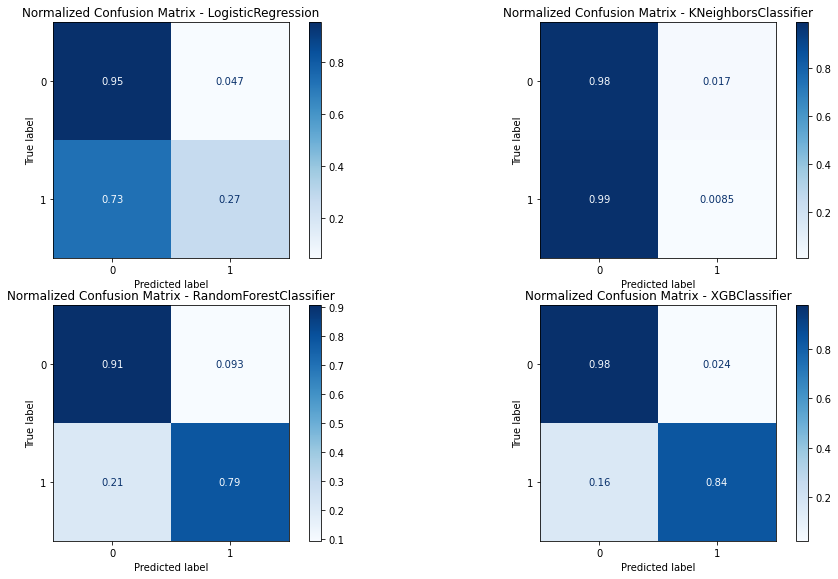

In [70]:
# Fit model with best estimators
b_grdsch_mdl_clf_rpt, b_grdsch_clf_dict = fit_eval_clf(b_grdsch_clfs, df_b_smote)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Not much improvement on predicting true negative.  But XGBoost did increased it true positive prediction slightly after the hyperparameter tuning.  KNN performed the worst for true positive prediction.</li>
    </ul>
</div>

### Plot Comparison Chart

In [71]:
# View classification report
b_grdsch_mdl_clf_rpt

LogisticRegression                                  \
                      precision    recall  f1-score     support   
Not Churn              0.889323  0.952580  0.919865  717.000000   
Churn                  0.484848  0.273504  0.349727  117.000000   
accuracy               0.857314  0.857314  0.857314    0.857314   
macro avg              0.687086  0.613042  0.634796  834.000000   
weighted avg           0.832580  0.857314  0.839882  834.000000   

             KNeighborsClassifier                                  \
                        precision    recall  f1-score     support   
Not Churn                0.858709  0.983264  0.916775  717.000000   
Churn                    0.076923  0.008547  0.015385  117.000000   
accuracy                 0.846523  0.846523  0.846523    0.846523   
macro avg                0.467816  0.495905  0.466080  834.000000   
weighted avg             0.749034  0.846523  0.790321  834.000000   

             RandomForestClassifier                                  \
                          precision    recall  f1-score     support   
Not Churn                  0.962963  0.906555  0.933908  717.000000   
Churn                      0.578616  0.786325  0.666667  117.000000   
accuracy                   0.889688  0.889688  0.889688    0.889688   
macro avg                  0.770790  0.846440  0.800287  834.000000   
weighted avg               0.909044  0.889688  0.896417  834.000000   

             XGBClassifier                                  
                 precision    recall  f1-score     support  
Not Churn         0.973574  0.976290  0.974930  717.000000  
Churn             0.852174  0.837607  0.844828  117.000000  
accuracy          0.956835  0.956835  0.956835    0.956835  
macro avg         0.912874  0.906948  0.909879  834.000000  
weighted avg      0.956543  0.956835  0.956679  834.000000

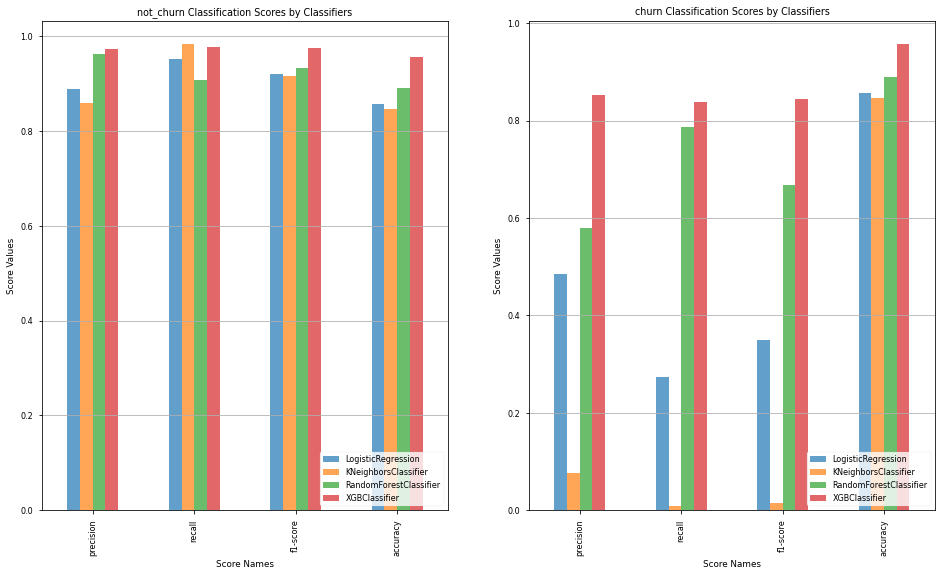

In [72]:
# Plot comparison chart
plot_clf_rpt(b_grdsch_mdl_clf_rpt, b_grdsch_clf_dict)

### Plot Performance Gain/Loo Tuned vs Base

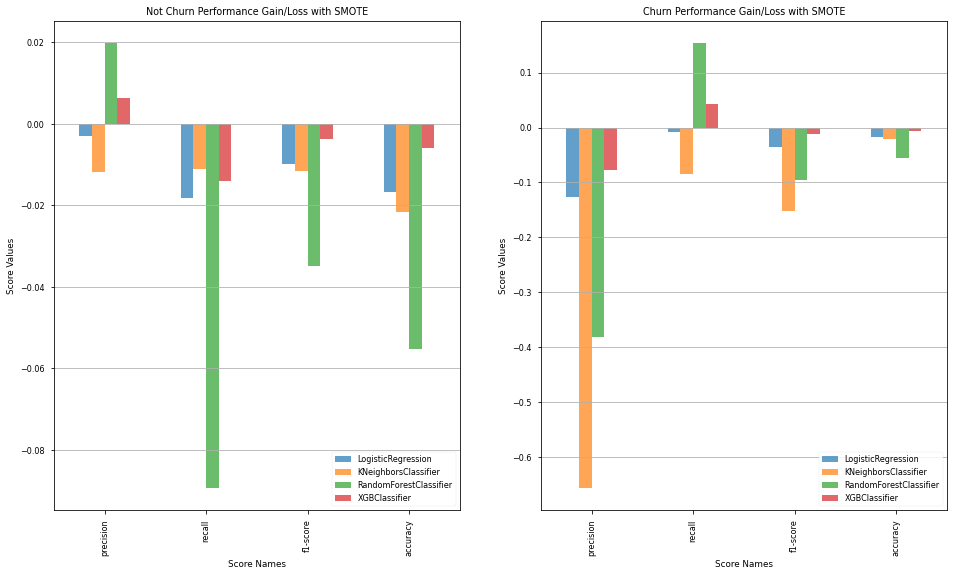

In [73]:
# Plot Performance Gain/Loss chart
plot_gain_loss(b_grdsch_mdl_clf_rpt, b_base_mdl_clf_rpt, {'f_churn': 'Not Churn', 't_churn': 'Churn'})

<div class="alert alert-block alert-info">
<b>Observations</b>
    <p>--- Not Churn Prediction ---</p>
        <ul>
            <li>Random Forest gained the most performance from the tunning.  The other three classifiers only showed a decrease in improvements compared to based model.</li>            
        </ul>
    <p>--- Churn Prediction ---</p>
        <ul>
            <li>Mostly a drop in prediction across the four classifiers.  KNN classifier posted the biggest drop in precision score.</li>
        </ul>
    <p>--- Conclusion ---</p>
         <ul>
            <li>XGBoost still yields the best scores among the models, especially the recall scores, which is what we are trying to optimize.  We will pick XGBoost as the model of choice for Model B. </li>
        </ul>   
</div>

## Model B - Model Evaluation

### Model Validation

In [74]:
# Compare train, test accuracy score
mdl_b_xg_clf = xgb.XGBClassifier(learning_rate=0.2, max_depth=7,
                                 n_estimators=250, random_state=36)

y_b_test_pred, y_b_train_acc, y_b_test_acc = mdl_validation('xgb', mdl_a_xg_clf, df_b_smote)

# y_b_test_pred, y_b_train_acc, y_b_test_acc = mdl_validation('xgb', mdl_a_xg_clf,
#                                                       X_b_train_smote, y_b_train_smote,
#                                                       X_b_test_ohe, y_b_test)

print(f'\n***** Train Accuracy: {y_b_train_acc * 100}%. ' +
      f'Test Accuracy:{round(y_b_test_acc * 100,2)}% *****')


***** Train Accuracy: 99.98%. Test Accuracy:95.68% *****


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Model B test accuracy score went up significantly, from 91.13 in Model A to 95.8%.</li>
        <li>Model B appears not to be overfitted.</li>
    </ul>
</div>


***** Model A AUC Score: 83.71% *****

***** Model B AUC Score: 90.69% *****


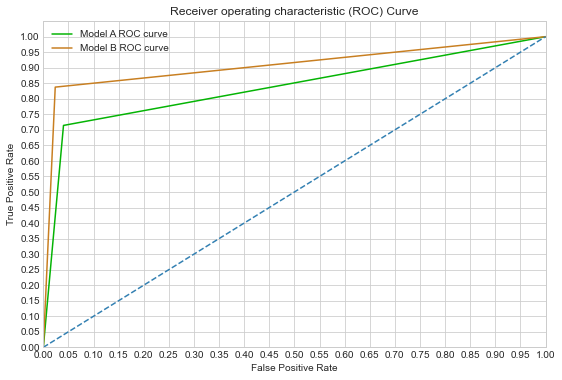

In [75]:
plot_roc_cur(y_b_test, y_b_test_pred, y_test, y_test_pred, sec=True)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Model B has a higher AUC score than Model A 90% vs 82%, which means Model B is about 8% higher in correctly distinguish the two labels than Model A.</li>
    </ul>
</div>

### Plot Performance Gain/Loss - Model B vs Model A

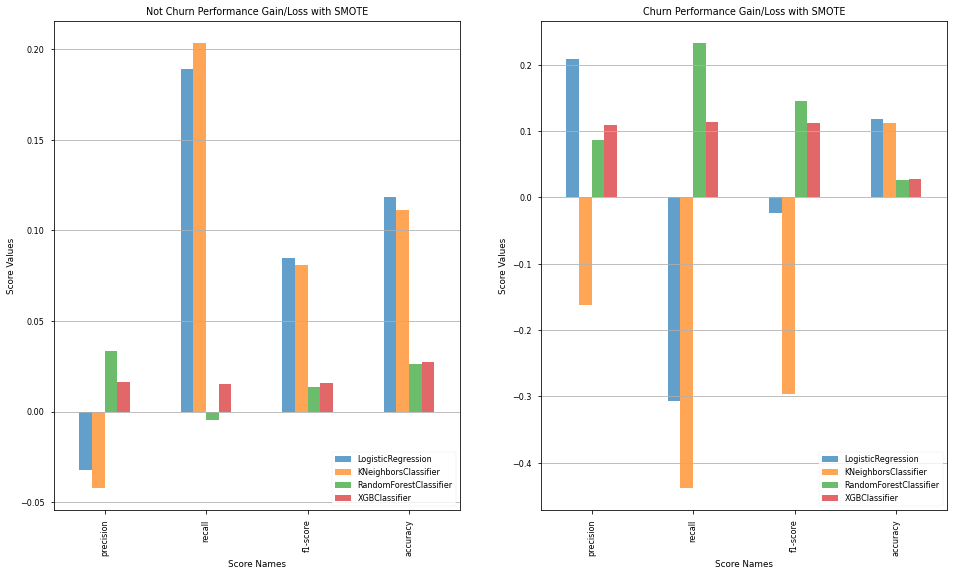

In [76]:
# Plot Performance Gain/Loss chart
plot_gain_loss(b_grdsch_mdl_clf_rpt, grdsch_mdl_clf_rpt, {'f_churn': 'Not Churn',
                                                      't_churn': 'Churn'})

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The XGBoost in Model B outperformed Model A in all aspect of the scores.</li>
        <li>Model B will be our final model and we will use in our next step, model interpretation.</li>
    </ul>
</div>

***
## Model Interpretation

### Prepare Data for Shap

In [77]:
# load JS visualization code to notebook
shap.initjs()

# Setup pipeline, transform data
xgb_pipe = Pipeline([('scaler', StandardScaler())])
x_b_train_smote_tmp = xgb_pipe.fit_transform(X_b_train_smote)
X_b_test_ohe_tmp = xgb_pipe.transform(X_b_test_ohe)

x_b_train_smote_sca = pd.DataFrame(x_b_train_smote_tmp, columns=X_b_train_smote.columns)
X_b_test_ohe_sca = pd.DataFrame(X_b_test_ohe_tmp, columns=X_b_test_ohe.columns)

# Fit model
xgb_clf =  mdl_b_xg_clf
xgb_clf.fit(x_b_train_smote_sca, y_b_train_smote)         

XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=250, random_state=36)

In [78]:
# !!! This cell takes about 5 mins to run !!!
# Compute shap values
explainer = shap.TreeExplainer(xgb_clf, x_b_train_smote_sca)
shap_values = explainer.shap_values(X_b_test_ohe_sca)

Passing 4266 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 831/834 [03:36<00:00]        

### Feature Important

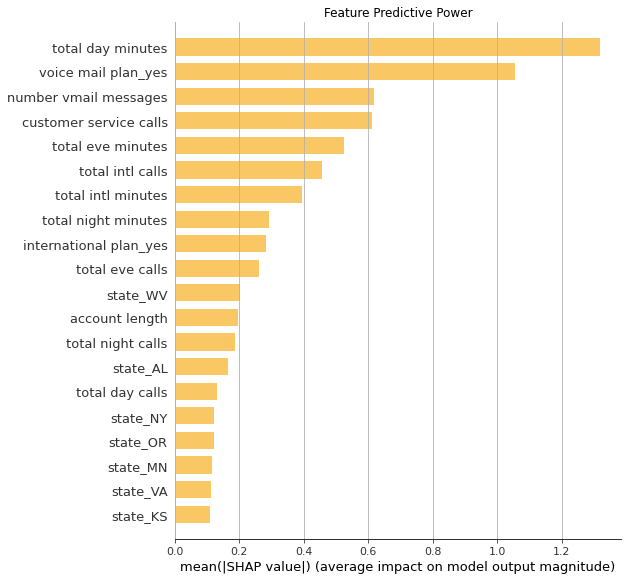

In [79]:
# plot feature important
fig = shap.summary_plot(shap_values, X_b_test_ohe_sca, plot_type="bar"
                        , show=False, color='#F9C764')
plt.title('Feature Predictive Power')
plt.grid(axis='x')
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The 'total day minutes' and 'voice mail plan_yes' features have the biggest impact on the model outcome. It changes the predicted churn probability by about 120% (approx. 1.2 on the x-axis) and 98% on average respectively.</li>
        <li>The 'number vmail messages' and 'customer service calls' came in third and fourth as the most influential features.</li>
    </ul>
</div>

### Shap Values Distribution by Features

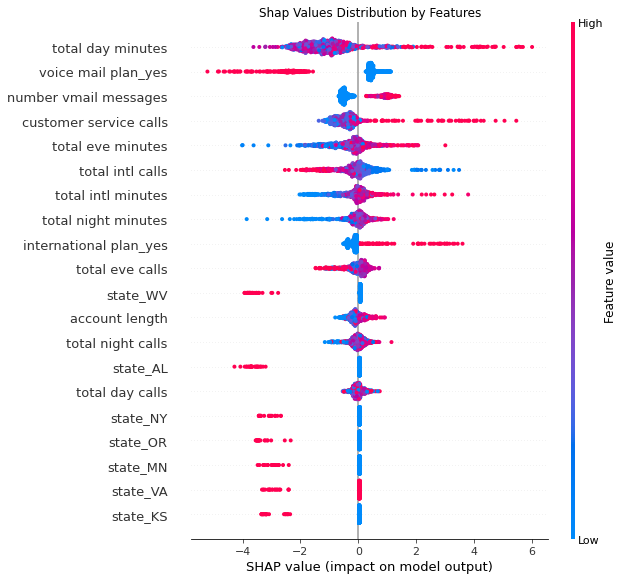

In [80]:
# Plot the Shap summary report which combines feature importance with feature effects
fig = shap.summary_plot(shap_values, X_b_test_ohe_sca, show=False)
plt.title('Shap Values Distribution by Features')
plt.show()

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In general, the higher the actual feature values in 'total day minutes' (red dots), the higher the prediction in the 'churn' label.  On the hand, the lower their actual feature values (blue dots), reduce the prediction for 'churn' label.</li>
        <li>Customers with voice mail plan tend not to churn while customers without a voice mail plan contribute more toward the churn prediction.</li>
        <li>High feature values in 'number vmial messages' has a positive impact in predicting the 'churn' label in the model outcomes.</li>
        <li>For feature 'customer service calls', the higher the number of calls to the customer service line, the higher the risk that the customers will churn.</li>
    </ul>
</div>

### Examine Individual Instance

In [81]:
# Find instances of 'Churn' & 'Not Churn'
n_churn_row = (y_b_test == 0).values.nonzero()[0][0]
churn_row = (y_b_test == 1).values.nonzero()[0][0]

In [82]:
# Examine features influnces on 'Not Churn' prediction
shap.force_plot(explainer.expected_value, shap_values[n_churn_row,:],
                X_b_test_ohe_sca.iloc[n_churn_row,:])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In this instance, the actual churn rate is False or 0.  Here we can how the the features in the model is working together to come to a false prediction.
        <li>In this case, the 'state_NV', 'total day minutes', 'customer services calls' and other features are pushing toward a False prediction while features like, 'voice mail plan_yes' and 'total intl minutes' are acting in the opposite direction.  Since the negative forces outweigh the positive forces, they push the model toward a False prediction.</li>
    </ul>
</div>

In [83]:
# Examine features influnces on 'Churn' prediction
shap.force_plot(explainer.expected_value, shap_values[churn_row,:],
                X_b_test_ohe_sca.iloc[churn_row,:])

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>In this instance, the actual value for the churn rate is true.  We can see how the model use the aggregate effects of 'customer service calls', 'total day minutes' and 'state_CA' to predict a true churn rate.</li>
    </ul>
</div>

### Global Instance Influence

In [84]:
# !!! Please select the top 4 features from the top dropdown for
#     the comments in the 'Observation' section !!!

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_b_test_ohe_sca)

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>This figure plots all the instance we saw above.  It show how each feature value has on the model outcomes.  The bigger the red area, more impact in predicting churn.  Blue area are the negative forces that push to reduce risk of churn.</li>
    </ul>
</div>

***
## Conclusion

<b>Our Classifier</b>
    <p>All of the selected supervised learning methods in this project are capable of tackling binary classification.  Each have their strengths and weaknesses for different business situations.  In our case of predicting the Churn rate, the XGBoost classifier out performed the other three classifiers in term of the accuracy, f1_score, precision and recall scores.  Especially the recall score because we need to identify all potential customers that are like to cancel their services.</p>
        <p>We picked Model B because Model B have a higher scorings in the classification report than Model A.  Furthermore, Model B seems to be less overfitting than Model A.  Lastly, Model B AUC score is significantly higher than Model A.</p>
        
<b>Recommendations</b>    
    <p>Based on the available data, our model is able to identify which explanatory variables have the biggest impact on the Churn rate.  We will based our recommendations based on our top four features.<p>
    <ol>
        <li><p>'Total day minutes': Customers with high number of minutes used during the day, have a greater chance of churn.  A remedy to such problem would be to review the pricing structure for total day minutes.  Perhaps, we can micro-segment the pricing structure for total day minutes charges.</p>
            <p>Another approach we can implement is to model what the airline industry is offering to their customer with the 'frequent-flyer miles'.  We could grand the heavy day time usage customers with VIP status and they will receive certain amount of benefits when they reach certain usage level.  Thus providing the justification to make more or longer call without feeling spending more.</p>
        </li>  
        <li>'Voice mail plan_yes':  Customers without a voice mail plan tend to end their services with the company.  It is possible that they find other competitors offering such feature without addition charges.  We should carry out a comparative analysis to see if we can match the competitions, in order to keep the customers happy.
        </li>
        <li>'No vmail messages': Are we charging customers when they exceed certain amount of voice mails?  Do they have a time length limit for storing voice messages?  Understanding what our competitors are offering is critical so we can provide competitive offerings.  Another point to take into consideration is the capacity of our infrastructure.  Usage analysis and capacity planning will need to be carried out so that new offerings by our company will not overtax on our daily operations.</li>
        <li>'Customer service calls':  The model indicates that customers with high number of service calls show higher risk of churn.  A analysis of the call nature will help us prioritize area of improvements.  Questions like is the call information or technical?  Are customers calling with the same questions?  If yes, it would suggest that more training are needed for the customer service agents. </li>
    </ol>
<b>Future work</b>
    <ol>
        <li>In this project, we have selected four different types of supervised learning algorithms namely, Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost, because each classifier employs different algorithm to optimize their predictions.  It would be interesting to see what type of results we could obtain, if we were to use other algorithms, such as Bayesian Classification or the Support Vector Machines.</li>
        <li>We can also try different techniques to deal with class imbalance problems, for instance, using oversampling and undersampling as well as combining over or undersampling with SMOTE.  
        <li>Each classifier come with number of parameters for fine tuning.  Finding the best combination of parameters can be computationally expensive.  In this project we selected the most common parameters for fine tuning.  If time allows, we can introduce more hyperparameters for each classifier to the grid search method and see where it will bring us in term of the model performances.